In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
import os
import json
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.utils import Sequence

# 1. Image and JSON Pre-processing

# Change JSON categories and convert extensions from jpg to png

In [ ]:
TRAIN_PATH = "/content/drive/MyDrive/Vision_project/Flavio_tests/training_updated_2.json"
TEST_PATH = "/content/drive/MyDrive/Vision_project/Flavio_tests/test_updated_2.json"
IMG_PATH = "/content/drive/MyDrive/Vision_project/images"
PROCESSED_IMG_PATH = "/content/drive/MyDrive/Vision_project/processed_images"

In [ ]:
import cv2
import numpy as np
# Apply pre-processing for the iages
def preprocess_image(image):
    image_rescaled = np.zeros_like(image, dtype=np.float32)
    for channel in range(image.shape[2]):
        channel_data = image[:, :, channel]
        min_val, max_val = channel_data.min(), channel_data.max()
        image_rescaled[:, :, channel] = (channel_data - min_val) / (max_val - min_val + 1e-8)

    image_rescaled = (image_rescaled * 255).astype(np.uint8)

    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    image_equalized = np.zeros_like(image_rescaled)
    for channel in range(image_rescaled.shape[2]):
        image_equalized[:, :, channel] = clahe.apply(image_rescaled[:, :, channel])

    return image_equalized

def preprocess_folder(input_folder, output_folder):


    os.makedirs(output_folder, exist_ok=True)

    for filename in os.listdir(input_folder):
        input_path = os.path.join(input_folder, filename)

        if filename.lower().endswith(('.png')):

            image = cv2.imread(input_path)

            if image is not None:

                preprocessed_image = preprocess_image(image)
                output_path = os.path.join(output_folder, filename)
                cv2.imwrite(output_path, preprocessed_image)
                print(f"Processed and saved: {output_path}")
            else:
                print(f"Could not read image: {input_path}")
        else:
            print(f"Skipped non-image file: {filename}")


input_folder = IMG_PATH
output_folder = PROCESSED_IMG_PATH

preprocess_folder(input_folder, output_folder)

Processed and saved: /content/drive/MyDrive/Vision_project/processed_images/4748ba2b-6771-41d9-93a5-af9ccd559261.png
Processed and saved: /content/drive/MyDrive/Vision_project/processed_images/46f5bd4f-8bea-48d1-a1da-4dea28e3b814.png
Processed and saved: /content/drive/MyDrive/Vision_project/processed_images/4736f545-1f1f-4d77-9241-d69cbf4dae35.png
Processed and saved: /content/drive/MyDrive/Vision_project/processed_images/4876c9d0-b386-48fb-84e8-91bf87529161.png
Processed and saved: /content/drive/MyDrive/Vision_project/processed_images/4a0a05e1-11ad-4bfc-bfa3-adf3b9bd0b56.png
Processed and saved: /content/drive/MyDrive/Vision_project/processed_images/48e2f0bd-2164-40c3-af43-1f2708359978.png
Processed and saved: /content/drive/MyDrive/Vision_project/processed_images/49c4dbd3-6269-4d4c-9648-a2146c57bab1.png
Processed and saved: /content/drive/MyDrive/Vision_project/processed_images/49b03a6e-6b26-4a96-a061-e05647a02138.png
Processed and saved: /content/drive/MyDrive/Vision_project/proce

In [ ]:
# Updated category mapping to include "difficult"
category_mapping = {
    "red blood cell": "uninfected",
    "leukocyte": "uninfected",
    "gametocyte": "infected",
    "ring": "infected",
    "trophozoite": "infected",
    "schizont": "infected",
    "difficult": "infected"
}

def update_json_file(json_file_path, output_file_path, exclude_difficult=True):
    with open(json_file_path, 'r') as f:
        data = json.load(f)

    updated_data = []
    for entry in data:
        old_pathname = entry["image"]["pathname"]
        new_pathname = old_pathname.replace("images", "processed_images")
        if new_pathname.endswith(".jpg"):
            new_pathname = new_pathname.replace(".jpg", ".png")
        entry["image"]["pathname"] = new_pathname

        updated_objects = []
        for obj in entry["objects"]:
            old_category = obj["category"]

            if exclude_difficult and old_category == "difficult":
                continue

            obj["category"] = category_mapping.get(old_category, "infected")
            updated_objects.append(obj)

        if updated_objects:
            entry["objects"] = updated_objects
            updated_data.append(entry)

    with open(output_file_path, 'w') as f:
        json.dump(updated_data, f, indent=4)

    print(f"Updated JSON saved to: {output_file_path}")

training_json_path = "/content/drive/MyDrive/Vision_project/training.json"
test_json_path = "/content/drive/MyDrive/Vision_project/test.json"

update_json_file(training_json_path, TRAIN_PATH,exclude_difficult=False)
update_json_file(test_json_path, TEST_PATH,exclude_difficult=False)

Updated JSON saved to: /content/drive/MyDrive/Vision_project/Flavio_tests/training_updated_2.json
Updated JSON saved to: /content/drive/MyDrive/Vision_project/Flavio_tests/test_updated_2.json


In [ ]:
import json

#This is only a check step with code taked from the Unet trainning
def verify_categories_and_get_stats(json_file_path, is_training=True):
    total_cells = 0
    infected_count = 0
    uninfected_count = 0
    invalid_categories = set()

    image_count = 0

    with open(json_file_path, 'r') as f:
        data = json.load(f)

    for entry in data:
        image_count += 1
        for obj in entry["objects"]:
            category = obj["category"]
            total_cells += 1
            if category == "infected":
                infected_count += 1
            elif category == "uninfected":
                uninfected_count += 1
            else:
                invalid_categories.add(category)
    print(f"Statistics for file: {json_file_path}")
    print(f"Total images: {image_count}")
    print(f"Total cells: {total_cells}")
    print(f"Infected cells: {infected_count}")
    print(f"Uninfected cells: {uninfected_count}")

    if invalid_categories:
        print(f"Invalid categories found: {invalid_categories}")
    else:
        print("All categories are valid ('infected' and 'uninfected').")

    return image_count

training_image_count = verify_categories_and_get_stats(TRAIN_PATH, is_training=True)
test_image_count = verify_categories_and_get_stats(TEST_PATH, is_training=False)

total_images = training_image_count + test_image_count
print("\nSummary:")
print(f"Total training images: {training_image_count}")
print(f"Total test images: {test_image_count}")
print(f"Total images: {total_images}")


Statistics for file: /content/drive/MyDrive/Vision_project/Flavio_tests/training_updated_2.json
Total images: 1208
Total cells: 80113
Infected cells: 2590
Uninfected cells: 77523
All categories are valid ('infected' and 'uninfected').
Statistics for file: /content/drive/MyDrive/Vision_project/Flavio_tests/test_updated_2.json
Total images: 120
Total cells: 5922
Infected cells: 308
Uninfected cells: 5614
All categories are valid ('infected' and 'uninfected').

Summary:
Total training images: 1208
Total test images: 120
Total images: 1328


# Bounding boxes method

In [ ]:
import json
import os

def update_image_path(json_file_path, output_file_path, prefix):

    with open(json_file_path, 'r') as f:
        data = json.load(f)

    for entry in data:
        original_path = entry["image"]["pathname"]
        entry["image"]["pathname"] = os.path.join(prefix, original_path.lstrip('/'))

    with open(output_file_path, 'w') as f:
        json.dump(data, f, indent=4)

    print(f"Updated JSON saved to: {output_file_path}")

train_json_path = TRAIN_PATH
test_json_path = TEST_PATH

updated_train_json_path = "/content/drive/MyDrive/Vision_project/Flavio_tests/training_box_2.json"
updated_test_json_path = "/content/drive/MyDrive/Vision_project/Flavio_tests/test_box_2.json"

prefix = "/content/drive/MyDrive/Vision_project"


update_image_path(train_json_path, updated_train_json_path, prefix)
update_image_path(test_json_path, updated_test_json_path, prefix)


Updated JSON saved to: /content/drive/MyDrive/Vision_project/Flavio_tests/training_box_2.json
Updated JSON saved to: /content/drive/MyDrive/Vision_project/Flavio_tests/test_box_2.json


In [ ]:
print(TRAIN_PATH)

/content/drive/MyDrive/Vision_project/Flavio_tests/training_updated_2.json


In [ ]:
updated_train_json_path = "/content/drive/MyDrive/Vision_project/Flavio_tests/training_box_2.json"
updated_test_json_path = "/content/drive/MyDrive/Vision_project/Flavio_tests/test_box_2.json"


In [ ]:
import json
import os
import torch
from torch.utils.data import Dataset
from PIL import Image
import numpy as np
# This class allow to create the dataset based on the annotations and the images of the folders

class CellDataset(Dataset):
    def __init__(self, json_file, image_root_dir, transforms=None):

        with open(json_file, "r") as f:
            self.data = json.load(f)

        self.image_root_dir = image_root_dir
        self.transforms = transforms

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):

        item = self.data[idx]
        image_path = os.path.join(self.image_root_dir, item["image"]["pathname"])
        image = Image.open(image_path).convert("RGB")
        image = np.array(image)


        boxes = []
        labels = []
        for obj in item["objects"]:
            bbox = obj["bounding_box"]
            boxes.append([
                bbox["minimum"]["c"],
                bbox["minimum"]["r"],
                bbox["maximum"]["c"],
                bbox["maximum"]["r"],
            ])
            labels.append(1 if obj["category"] == "infected" else 2)

        target = {
            "bboxes": boxes,
            "labels": labels
        }

        #This section allow to apply the transformation given, like the conversion to tensors and normalization of the image values

        if self.transforms:
            transformed = self.transforms(image=image, bboxes=target["bboxes"], labels=target["labels"])
            image = transformed['image']

            target = {
                "boxes": torch.tensor(transformed['bboxes'], dtype=torch.float32),
                "labels": torch.tensor(transformed['labels'], dtype=torch.int64)
            }

        else:

            image = torch.tensor(image, dtype=torch.float32).permute(2, 0, 1) / 255.0
            target = {
                "boxes": torch.tensor(target["bboxes"], dtype=torch.float32),
                "labels": torch.tensor(target["labels"], dtype=torch.int64)
            }

        return image, target


In [ ]:
import albumentations as A
from albumentations.pytorch import ToTensorV2

albumentations_transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.Rotate(limit=15, p=0.5),
    A.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.1),
    A.GaussianBlur(blur_limit=(5, 9), sigma_limit=(0.1, 2.0), p=0.5),
    A.RandomBrightnessContrast(p=0.5),
    A.RandomResizedCrop(height=256, width=256, scale=(0.8, 1.0), p=0.5),
    A.GridDistortion(p=0.3),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ToTensorV2()
], bbox_params=A.BboxParams(format='pascal_voc', label_fields=['labels'], min_visibility=0.3))


/usr/local/lib/python3.11/dist-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 2.0.2 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


# Just Weigth

In [ ]:
from torchvision import transforms
from torch.utils.data import DataLoader

from torchvision import transforms

train_dataset = CellDataset(updated_train_json_path, PROCESSED_IMG_PATH, transforms=albumentations_transform)

test_transform = A.Compose([
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ToTensorV2()
], bbox_params=A.BboxParams(format='pascal_voc', label_fields=['labels']))
test_dataset = CellDataset(updated_test_json_path, PROCESSED_IMG_PATH, transforms=test_transform)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, collate_fn=lambda x: tuple(zip(*x)))
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False, collate_fn=lambda x: tuple(zip(*x)))




/usr/local/lib/python3.11/dist-packages/albumentations/core/composition.py:205: UserWarning: Got processor for bboxes, but no transform to process it.
  self._set_keys()


In [ ]:
# Get a sample from the dataset
image, target = train_dataset[0]

print("Image shape:", image.shape)
print("Bounding boxes:", target['boxes'])
print("Labels:", target['labels'])

assert target["boxes"].shape[1] == 4, "Bounding boxes should be in format [x_min, y_min, x_max, y_max]"


Image shape: torch.Size([3, 256, 256])
Bounding boxes: tensor([[  2.1865,   6.3345,  20.4071,  28.3959],
        [ 27.1488,  47.1809,  45.3694,  69.6792],
        [ 99.1203, 108.7782, 118.7986, 133.0239],
        [152.8712, 170.1570, 171.4562, 192.8737],
        [100.0313, 191.1263, 122.2605, 216.0273],
        [  0.0000, 195.2764,  13.1189, 217.1194],
        [  9.1103, 179.7679,  30.6107, 203.1399],
        [211.3594, 142.8532, 227.7580, 165.3515],
        [ 44.4584,  70.7713,  65.7765,  96.1092],
        [182.2064,  21.8430, 200.0626,  42.5939],
        [ 21.6826,  70.9898,  41.1786,  94.3618],
        [244.5210, 155.5222, 256.0000, 174.3072],
        [191.6811, 165.7884, 208.4441, 183.0444],
        [146.8584,  50.4573, 169.4520,  74.7031],
        [246.5253, 218.6485, 256.0000, 243.3311],
        [ 57.9416,  53.2969,  73.7936,  76.6689],
        [220.8342, 162.9488, 240.3302, 183.0444],
        [188.9480, 186.5392, 206.6221, 209.2560],
        [127.5445,  79.0717, 147.5872, 101.13

In [ ]:
import torch
from torchvision.models.detection.faster_rcnn import FasterRCNN
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
 # This function allow to use a wigthed trainning function, with the intention of give more weigth to the ifnected class.
def get_weighted_model(num_classes, class_weights):
    model = fasterrcnn_resnet50_fpn(pretrained=True)
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    model.roi_heads.box_predictor.loss_cls = torch.nn.CrossEntropyLoss(weight=torch.tensor(class_weights).float())
    return model

class_weights = [0.1, 1.0, 11.0]  # Background, uninfected, infected
num_classes = 3
model = get_weighted_model(num_classes, class_weights)


In [ ]:
import torch
import time

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

optimizer = torch.optim.AdamW(model.parameters(), lr=0.0001)

scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

In [ ]:

num_epochs = 6
for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0


    start_time = time.time()

    for images, targets in train_loader:
        images = [img.to(device) for img in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]


        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())


        optimizer.zero_grad()
        losses.backward()
        optimizer.step()


        epoch_loss += losses.item()

    scheduler.step()


    end_time = time.time()
    epoch_duration = end_time - start_time

    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {epoch_loss:.4f}, Time: {epoch_duration:.2f} seconds")
    print(f"Learning Rate: {scheduler.get_last_lr()[0]:.6f}")


Epoch 1/6, Loss: 100.8165, Time: 462.07 seconds
Learning Rate: 0.000100
Epoch 2/6, Loss: 76.0334, Time: 460.86 seconds
Learning Rate: 0.000100
Epoch 3/6, Loss: 70.1532, Time: 458.57 seconds
Learning Rate: 0.000100
Epoch 4/6, Loss: 68.1211, Time: 456.87 seconds
Learning Rate: 0.000100
Epoch 5/6, Loss: 66.2356, Time: 460.44 seconds
Learning Rate: 0.000010
Epoch 6/6, Loss: 64.0666, Time: 459.68 seconds
Learning Rate: 0.000010


# Save model

In [ ]:
import torch

# Path to save the model
state_dict_path = "/content/drive/MyDrive/Vision_project/trials_infected/bounding_boxes_model_state_dict_011_augment_2.pth"
full_model_path = "/content/drive/MyDrive/Vision_project/trials_infected/bounding_boxes_model_full_011_augment_2.pth"


torch.save(model.state_dict(), state_dict_path)

torch.save(model, full_model_path)

print(f"Model state_dict saved to {state_dict_path}")
print(f"Full model saved to {full_model_path}")


Model state_dict saved to /content/drive/MyDrive/Vision_project/trials_infected/bounding_boxes_model_state_dict_011_augment_2.pth
Full model saved to /content/drive/MyDrive/Vision_project/trials_infected/bounding_boxes_model_full_011_augment_2.pth


#Load model

In [ ]:
import torch
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor


model_path = "/content/drive/MyDrive/Vision_project/trials_infected/bounding_boxes_model_full_07_augment2v.pth"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model_2 = torch.load(model_path, map_location=device)

model_2.to(device)
model_2.eval()

print("Model successfully loaded as model_2!")


<ipython-input-8-6b1de64213ef>:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_2 = torch.load(model_path, map_location=device)


Model successfully loaded as model_2!


In [ ]:


import torch
from torchvision.ops import box_iou

# In thsi case we avaluate th emodel rpeditions comparind the generated model bounding boxes and the ones given by the dataset

def evaluate_model_per_category(model, data_loader, device):

    model.eval()
    category_metrics = {
        'infected': {'iou': 0, 'correct': 0, 'total': 0, 'predicted': 0, 'false_positives': 0, 'false_negatives': 0},
        'uninfected': {'iou': 0, 'correct': 0, 'total': 0, 'predicted': 0, 'false_positives': 0, 'false_negatives': 0}
    }

    with torch.no_grad():
        for images, targets in data_loader:
            images = [img.to(device) for img in images]


            targets = [{
                "boxes": torch.as_tensor(t["boxes"], dtype=torch.float32).to(device),
                "labels": torch.as_tensor(t["labels"], dtype=torch.int64).to(device)
            } for t in targets]

            # Get model predictions
            outputs = model(images)

            for i, output in enumerate(outputs):
                pred_boxes = output['boxes'].to(device)
                pred_labels = output['labels'].to(device)
                gt_boxes = targets[i]['boxes']
                gt_labels = targets[i]['labels']


                for gt_label in gt_labels:
                    if gt_label.item() == 1:
                        category_metrics['infected']['total'] += 1
                    elif gt_label.item() == 2:
                        category_metrics['uninfected']['total'] += 1
                for pred_label in pred_labels:
                    if pred_label.item() == 1:
                        category_metrics['infected']['predicted'] += 1
                    elif pred_label.item() == 2:
                        category_metrics['uninfected']['predicted'] += 1

                if pred_boxes.size(0) > 0 and gt_boxes.size(0) > 0:
                    ious = box_iou(pred_boxes, gt_boxes)
                    matched_gt_indices = set()
                   # Apply a threshold for the rpedictions
                    for j, iou in enumerate(ious.max(dim=1)[0]):
                        pred_label = pred_labels[j].item()
                        gt_idx = ious[j].argmax().item()

                        if gt_idx in matched_gt_indices:
                            continue
                        matched_gt_indices.add(gt_idx)

                        gt_label = gt_labels[gt_idx].item()

                        if iou > 0.4:
                            if pred_label == gt_label:
                                if pred_label == 1:
                                    category_metrics['infected']['correct'] += 1
                                elif pred_label == 2:
                                    category_metrics['uninfected']['correct'] += 1

                        if gt_label == 1:
                            category_metrics['infected']['iou'] += iou.item()
                        elif gt_label == 2:
                            category_metrics['uninfected']['iou'] += iou.item()

                category_metrics['infected']['false_positives'] = category_metrics['infected']['predicted'] - category_metrics['infected']['correct']
                category_metrics['infected']['false_negatives'] = category_metrics['infected']['total'] - category_metrics['infected']['correct']
                category_metrics['uninfected']['false_positives'] = category_metrics['uninfected']['predicted'] - category_metrics['uninfected']['correct']
                category_metrics['uninfected']['false_negatives'] = category_metrics['uninfected']['total'] - category_metrics['uninfected']['correct']

    for category, metrics in category_metrics.items():
        total = metrics['total']
        correct = metrics['correct']
        predicted = metrics['predicted']
        iou_sum = metrics['iou']

        metrics['avg_iou'] = iou_sum / total if total > 0 else 0
        metrics['accuracy'] = correct / total if total > 0 else 0
        metrics['precision'] = correct / predicted if predicted > 0 else 0
        metrics['recall'] = correct / total if total > 0 else 0

    return category_metrics


category_metrics = evaluate_model_per_category(model_2, test_loader, device)

for category, metrics in category_metrics.items():
    print(f"Category: {category}")
    print(f"  Average IoU: {metrics['avg_iou']:.4f}")
    print(f"  Accuracy: {metrics['accuracy']:.4f}")
    print(f"  Precision: {metrics['precision']:.4f}")
    print(f"  Recall: {metrics['recall']:.4f}")
    print(f"  False Positives: {metrics['false_positives']}")
    print(f"  False Negatives: {metrics['false_negatives']}")




Category: infected
  Average IoU: 0.8553
  Accuracy: 0.7045
  Precision: 0.4887
  Recall: 0.7045
  False Positives: 227
  False Negatives: 91
Category: uninfected
  Average IoU: 0.8534
  Accuracy: 0.9672
  Precision: 0.8015
  Recall: 0.9672
  False Positives: 1345
  False Negatives: 184


In [ ]:

total_params = sum(p.numel() for p in model_2.parameters())
print(f"Total Parameters: {total_params:,}")

Total Parameters: 41,304,286


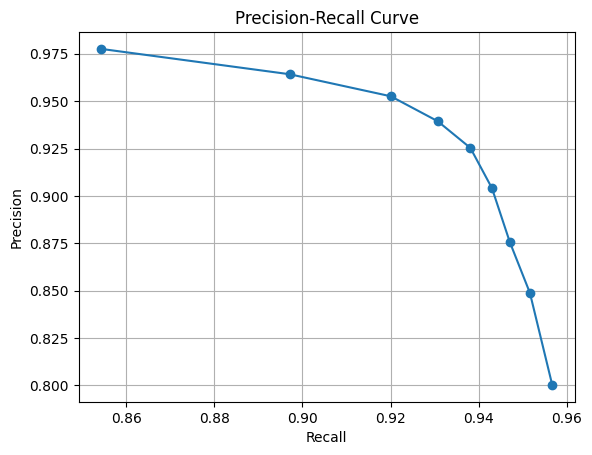

In [ ]:
import matplotlib.pyplot as plt

thresholds = np.linspace(0.1, 0.9, 9)
precisions = []
recalls = []

for t in thresholds:
    results = evaluate_with_threshold(model, test_loader, device, threshold=t)
    precisions.append(results["Precision"])
    recalls.append(results["Recall"])

plt.plot(recalls, precisions, marker='o')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.grid()
plt.show()


In [ ]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import cv2
from torchvision.ops import box_iou

#To plot the images we used the folowing, consideringt he normalization steps

MEAN = np.array([0.485, 0.456, 0.406])
STD = np.array([0.229, 0.224, 0.225])

def denormalize_image(tensor_image):

    image = tensor_image.permute(1, 2, 0).cpu().numpy()
    image = (image * STD) + MEAN
    image = np.clip(image * 255, 0, 255).astype(np.uint8)
    return image

def draw_boxes(image, boxes, labels, color_map, line_type=cv2.LINE_4):

    for box, label in zip(boxes, labels):
        color = color_map.get(label, (255, 255, 255))
        cv2.rectangle(image,
                      (int(box[0]), int(box[1])),
                      (int(box[2]), int(box[3])),
                      color, 6, line_type)
    return image

def visualize_predictions(model, data_loader, device, num_samples=5):

    model.eval()
    images_shown = 0


    color_map_gt = {1: (255, 0, 0), 2: (0, 0, 255)}
    color_map_pred = {1: (255, 0, 0), 2: (0, 0, 255)}

    with torch.no_grad():
        for images, targets in data_loader:
            images = [img.to(device) for img in images]

            outputs = model(images)

            for idx in range(len(images)):
                if images_shown >= num_samples:
                    break

                img = denormalize_image(images[idx])

                gt_boxes = targets[idx]['boxes'].cpu().numpy()
                gt_labels = targets[idx]['labels'].cpu().numpy()

                pred_boxes = outputs[idx]['boxes'].detach().cpu().numpy()
                pred_labels = outputs[idx]['labels'].detach().cpu().numpy()

                fig, ax = plt.subplots(1, 3, figsize=(18, 6))

                ax[0].imshow(img)
                ax[0].set_title("Original Image")
                ax[0].axis("off")

                img_gt = img.copy()
                img_gt = draw_boxes(img_gt, gt_boxes, gt_labels, color_map_gt)
                ax[1].imshow(img_gt)
                ax[1].set_title("Ground Truth\nGreen: Infected, Blue: Uninfected")
                ax[1].axis("off")

                img_pred = img.copy()
                img_pred = draw_boxes(img_pred, pred_boxes, pred_labels, color_map_pred, line_type=cv2.LINE_AA)
                ax[2].imshow(img_pred)
                ax[2].set_title("Predicted\nRed: Infected, Yellow: Uninfected")
                ax[2].axis("off")

                plt.tight_layout()
                plt.show()

                images_shown += 1

            if images_shown >= num_samples:
                break


visualize_predictions(model_2, test_loader, device, num_samples=5)


Output hidden; open in https://colab.research.google.com to view.